<a href="https://colab.research.google.com/github/kolikaran1992/Neural-Networks/blob/main/Self_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

SEED = 49

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams.update({'axes.titlesize': 20,
                     'axes.labelsize': 15,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10
                     })

from scipy.special import softmax

# DEFINITION

In NLP, attention is a modelling technique through which words in a sentence learn which words to pay attention to for downstream tasks. As an example, consider the following sentences

1. "We spent long evenings talking in my sitting-room while he played the music he had chosen and explained his ideas"
2. "A while and a time for you to respect yourself will be at an end"

The meaning of the word "while" is different in both the sentences, as the model tries to translate it, the model will benefit if it knows the right words to look at. As it happens to be the case, the attention mechanism does just that

# INTUITION



In [ ]:
NUM_WORDS = 5 # example shown below might not hold if this is changed
np.random.seed(42)
word_vectors = np.random.normal(size=(NUM_WORDS, 2))
word_vectors

array([[ 0.49671415, -0.1382643 ],
       [ 0.64768854,  1.52302986],
       [-0.23415337, -0.23413696],
       [ 1.57921282,  0.76743473],
       [-0.46947439,  0.54256004]])

In [ ]:
texts = [f'word_{i}' for i in range(1, NUM_WORDS+1)]

In [ ]:
def plot_vector(vector, ax, start_vector=(0,0), color='red', text='random'):
    ax.plot([start_vector[0], vector[0]], [start_vector[1], vector[1]], ls='--', color=color)
    ax.scatter(*vector.reshape(-1,1), marker='o', color=color)
    ax.text(vector[0],
         vector[1],
         "{}".format(text),
        #  transform=plt.gca().transAxes
            )
    # ax.grid()

rotation_t = lambda theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

Let [word_1, word_2, word_3, word_4, word_5] be the tokens of a sentence. Their corresponding word vectors (dimensionality chosen to be 2 to explain the example)

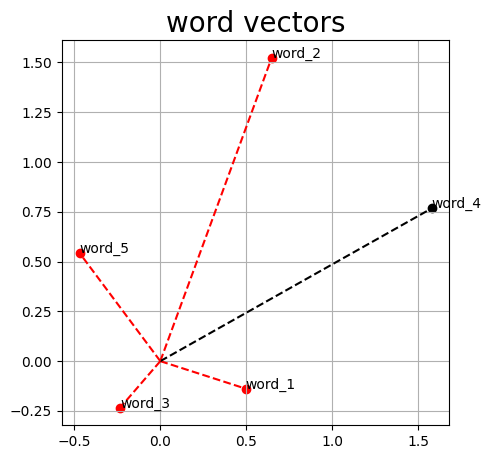

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

for vector, text, clr in zip(word_vectors, texts, ['red', 'red', 'red', 'black', 'red']):
    plot_vector(vector, axes, text=text, color=clr)
    axes.grid()
    axes.set_title('word vectors')

plt.show()

Suppose in our downstream task we are currently processing "word_4", and for the down stream task to work, the model needs to pay attention to "word_2" while processing "word_4". Let's see the dot product attention score of word_4's vector with the the rest

In [ ]:
softmax(np.matmul(word_vectors, word_vectors.T), axis=1)[3]

array([0.05788675, 0.26291847, 0.01695762, 0.6410126 , 0.02122457])

As it is evident from the plot too, the attention score b/w word_4 and word_2 is quite low. The attention mechanism helps by linearly transforming the word vectors such that the attention scores of the transformed vectors is what the downstream task needs it to be (max attention score b/w word_4 and word_2 in the example above)

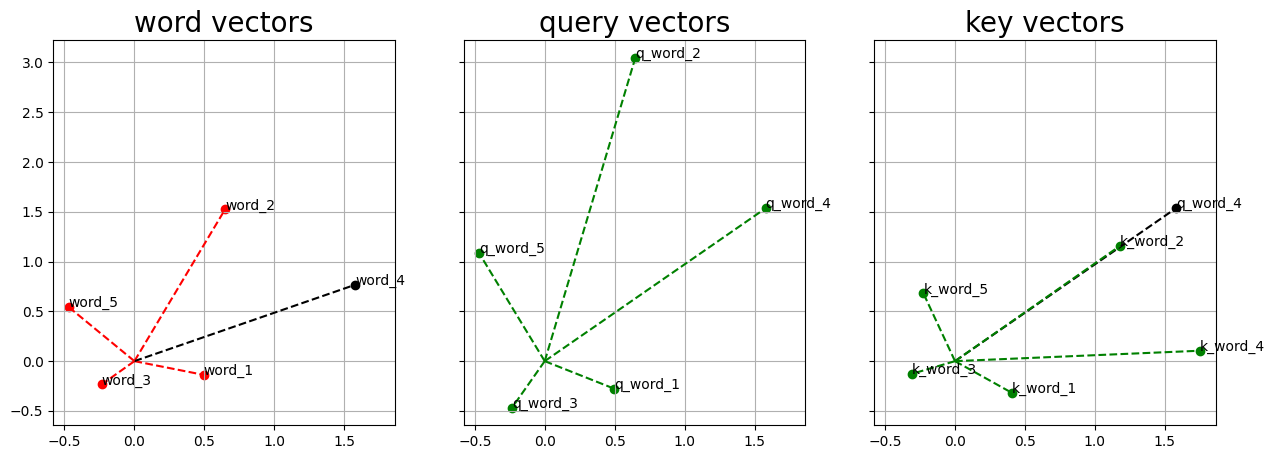

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(5*3, 5), sharex=True, sharey=True)

for vector, text, clr in zip(word_vectors, texts, ['red', 'red', 'red', 'black', 'red']):
    plot_vector(vector, axes[0], text=text, color=clr)
    axes[0].grid()
    axes[0].set_title('word vectors')

Wq = np.array([[1,0], [0,2]])
query_vectors = np.matmul(Wq, word_vectors.T).T # linear transformation of word_vectors

for vector, text in zip(query_vectors, texts):
    plot_vector(vector, axes[1], text=f'q_{text}', color='green')
    axes[1].grid()
    axes[1].set_title('query vectors')

# shear_t = np.array([[1, 1.3], [0, 1]])
# scale_t = np.array([[1, 0], [0, 2]])
# transformation = np.matmul(np.matmul(rotation_t(-np.pi/60), shear_t), scale_t)
Wk = rotation_t(-np.pi/8)

key_vectors = np.matmul(
    Wk
    ,word_vectors.T).T

plot_vector(query_vectors[3], axes[2], text=f'q_{texts[3]}', color='black')

for vector, text in zip(key_vectors, texts):
    plot_vector(vector, axes[2], text=f'k_{text}', color='green')
    axes[2].grid()
    axes[2].set_title('key vectors')

# plt.grid()
plt.show()

word vectors (left), query vectors (middle), key vectors with the query vector for word_4 shown in black (right)

In [ ]:
np.round(softmax(np.matmul(query_vectors, key_vectors.T), axis=1), 4)[3]

array([0.0192, 0.6312, 0.0084, 0.3084, 0.0328])

It is clear from the above plot that there exists a linear transformation that maximizes the attention score b/w word_2 and word_4

**NOTE**

We did not use positional encoding anywhere above to achieve the above, this hints that the attention mechanism does not rely solely on the alternating sin and cosine encodings to be able to attend to relative positions

# MULTI HEAD ATTENTION

While processing a particular word in the sentence in some NLP task, some times it is necessary for the model to be able to atted to multiple words at once. Since linear transformations transform all the vectors at once, it may not be possible for a single linear transformation to be able to maximize the dot product attention score of the required word vectors with the desired word vector (as can be seen in the previous plot)

To overcome this challenge, we can use multiple linear transformations. To be able to do it parallely with no more operations as compared to vanilla attention, we can logically partition the linear transformations in equal parts and operate on the lower dimensional representations of the transformed vectors

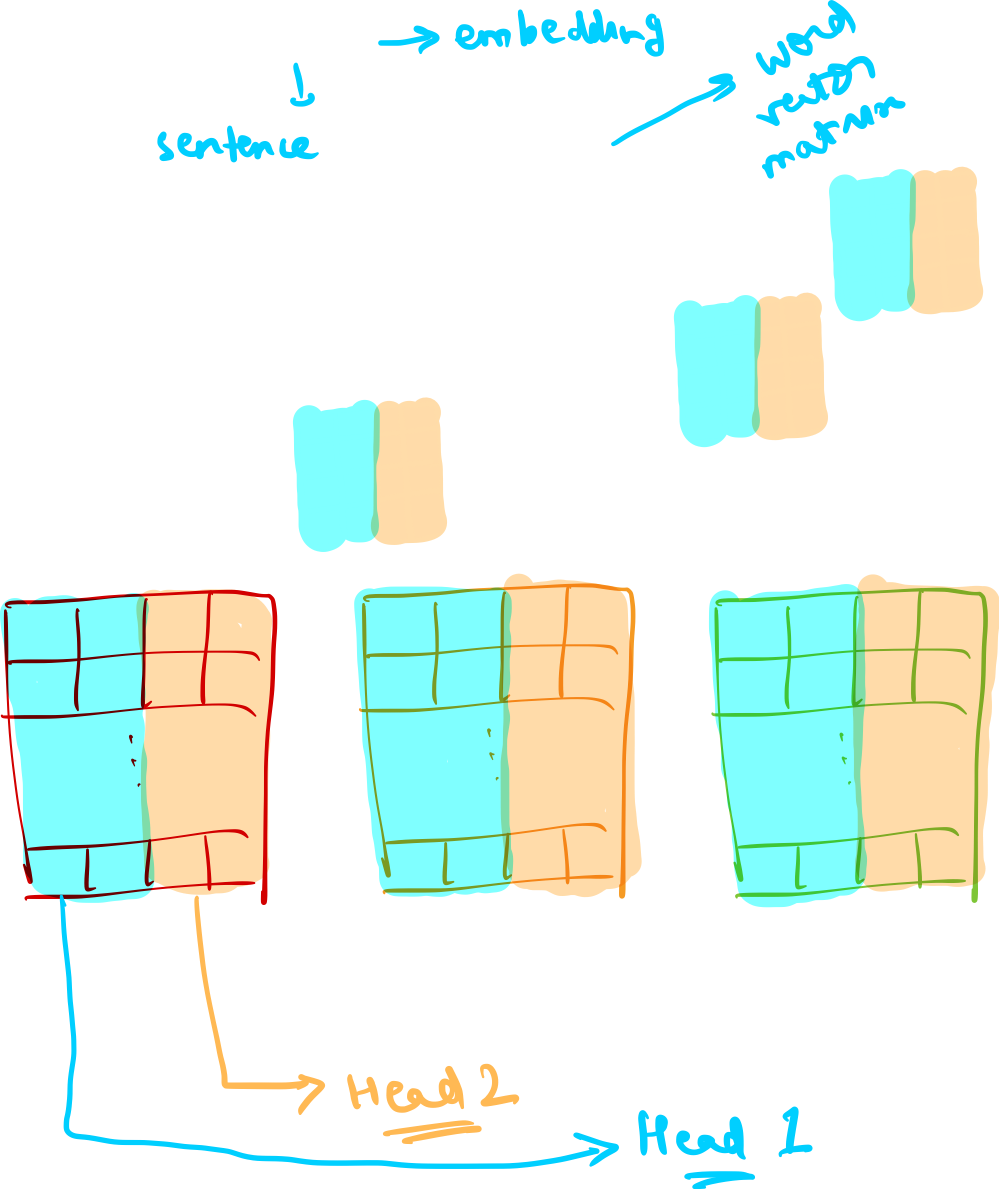

In the above image, different highlighted sections represent different logical sections of the linearly transformed matrices. The attention output is generated on each of them separately and then the final attention output becomes the concatenation of the different logical heads